In [64]:
import pandas as pd
import numpy as np
import math
import time
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import copy

data = open("Train.txt").read()

In [2]:
lines_of_data = data.splitlines()
df = pd.DataFrame([sub.split(",") for sub in lines_of_data])

In [3]:
def divide_data(data):
    Y = data.iloc[:, 0].to_numpy(dtype = int)
    X = data.iloc[:, 1:].to_numpy(dtype = float)
    
    return X , Y

In [4]:
def gini_index(sections,labels):
    total_size = float(sum([len(section) for section in sections]))
    gini = 0
    
    for section in sections:
        
        section_size = len(section)
        if section_size == 0:
            continue
            
        score = 0
        for label in labels:
            p = (section.count(label)/section_size)
            score += p*p
        
        gini += (1-score)*(section_size/total_size)
    
    return gini

In [5]:
def split(X,Y,feature,value):
    left = []
    right= []
    
    i =0
    for row in X:
        if row[feature] <= value:
            left.append(Y[i])
        else:
            right.append(Y[i])
        i+=1
            
    return left , right

In [6]:
class Classifier:
    def __init__(self, f_val,f_index,l_label,r_label):
        self.feature_value = f_val
        self.feature_index = f_index
        self.left_label = l_label
        self.right_label = r_label
        self.alpha = 0
        

In [7]:
def get_label(y,label):
    label_count = -math.inf
    final_label = math.inf
    
    for l in label:
        if label_count < y.count(l):
            label_count = y.count(l)
            final_label = l
    
    return final_label

In [8]:
def best_split(X,Y):
    feature_val = 0
    feature_index = 0
    best_gini = math.inf
    labels = [3,5]
    left_label = 0
    right_label = 0
    
    for feature in range(len(X[0])):
        s = set()
        for row in X:
            
            if row[feature] not in s:
                s.add(row[feature])
                
                left_set , right_set = split(X,Y,feature,row[feature])

                if len(left_set) == 0 or len(right_set)==0:
                    continue

                current_gini = gini_index([left_set,right_set],labels)

                if current_gini < best_gini:
                    feature_val = row[feature]
                    feature_index = feature
                    best_gini = current_gini
                    left_label = get_label(left_set,labels)
                    right_label= get_label(right_set,labels)
    
    return Classifier(feature_val,feature_index,left_label,right_label)

In [9]:
def predict(c,data):
    prediction = []
    
    for row in data:
        if row[c.feature_index] <= c.feature_value:
            prediction.append(c.left_label)
        else:
            prediction.append(c.right_label)
    
    return prediction

In [10]:
def find_error(Y,Y_pred,w):
    
    return (sum(w * (np.not_equal(Y, Y_pred)).astype(int)))/sum(w)

In [11]:
def update_weights(alpha,Y,Y_pred,w):
    
    counter =0
    
    for i in range(0,len(w)):
        if Y[i]==Y_pred[i]:
            w[i] = w[i] * np.exp(-1*alpha)
        else:
            w[i] = w[i] * np.exp(1*alpha)
        
        counter+=1
    
    
    return w/np.sum(w)

In [12]:
def ada_boost(X_train,Y_train,rounds):
    
    N = len(Y_train)
    
    w = np.ones(N)/N
    
    classifiers = []
    
    for k in range(rounds):
        
        sample =  df.sample(n=df.shape[0],axis = 0,replace=True,weights=w)

        X,Y = divide_data(sample)
    
        c = best_split(X,Y)
    
        Y_pred = predict(c,X_train)
        
        err = find_error(Y_train,Y_pred,w)
        
        if err > 0.5:
            w = np.ones(N)/ N
            continue

        alpha = 0.5*(np.log((1 - err)/err))
        
        c.alpha = alpha
        
        classifiers.append(c)
        
        w = update_weights(alpha,Y_train,Y_pred,w)
        
    return classifiers

In [14]:
def final_prediction(classifiers,X):
    y_pred = []
    
    for row in X:
        final_class = 0
        
        for c in classifiers:
            if row[c.feature_index] <= c.feature_value:
                if c.left_label == 3:
                    final_class -= c.alpha
                elif c.left_label == 5:
                    final_class += c.alpha
            else:
                if c.right_label == 3:
                    final_class -= c.alpha
                elif c.right_label == 5:
                    final_class += c.alpha
        
        if final_class < 0:
            y_pred.append(3)
        else:
            y_pred.append(5)
    
    return y_pred
    

In [15]:
def compute_accuracy(y, y_pred):
    total = 0 
    for i in range(len(y)):
        if y[i] == y_pred[i]:
            total = total + 1
    
    accuracy = (total/len(y))
    return accuracy

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


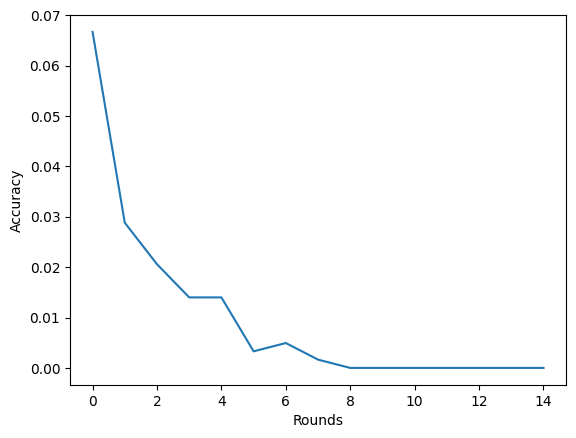

In [16]:
X_train,Y_train = divide_data(df)

rounds= [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
accuracies = []

ensembles_classifiers = {}

for i in range(len(rounds)):
    classifiers = ada_boost(X_train,Y_train,rounds[i])
    ensembles_classifiers[rounds[i]] = classifiers
    y_pred2 = final_prediction(classifiers,X_train)
    accuracies.append(1-compute_accuracy(Y_train,y_pred2))
    
plt.plot(accuracies)
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.show()

#Please ignore the 1.0 being printed. It was for debugging purposes.

In [27]:
test_data = open("Test.txt").read()

lines_of_data = test_data.splitlines()
df_test = pd.DataFrame([sub.split(",") for sub in lines_of_data])

X_test = df_test.to_numpy(dtype = float)
test_accuracies = []

In [30]:
for r in rounds:
    
    y_pred2 = final_prediction(ensembles_classifiers[r],X_test)
    
    fl = open("Pred"+ str(r) + ".csv","w")
    
    for p in y_pred2:
        fl.write(str(p))
        fl.write("\n")
        

In [40]:
ensembles_classifiers[110] = ada_boost(X_train,Y_train,110)
ensembles_classifiers[130] = ada_boost(X_train,Y_train,130)
ensembles_classifiers[150] = ada_boost(X_train,Y_train,150)
ensembles_classifiers[170] = ada_boost(X_train,Y_train,170)
ensembles_classifiers[190] = ada_boost(X_train,Y_train,190)

1.0
1.0
1.0
1.0
1.0


In [ ]:
decision_clf = DecisionTreeClassifier()
decision_clf.fit(X_train,Y_train)
y_pred2 = decision_clf.predict(X_test).astype(int)

fl = open("Decision_Tree_Lib.csv","w")

for p in y_pred2:
    fl.write(str(p))
    fl.write("\n")

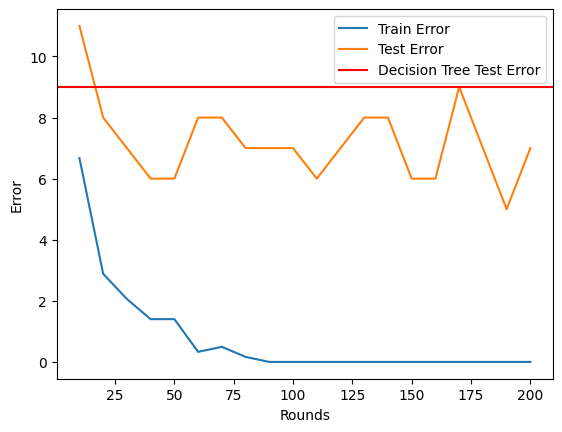

In [69]:
training_errors = []
rounds= [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]

for i in range(len(rounds)):
    y_pred2 = final_prediction(ensembles_classifiers[rounds[i]],X_train)
    training_errors.append((1-compute_accuracy(Y_train,y_pred2))*100)
    
## Test error from miner in the sequence of ada boost rounds
total_error = [11,8,7,6,6,8,8,7,7,7,6,7,8,8,6,6,9,7,5,7]

# Test error for single decison tree from miner.
decision_tree_error = 9

plt.plot(rounds,training_errors,label = 'Train Error')
plt.plot(rounds,total_error, label = "Test Error")
plt.axhline(y=decision_tree_error, color='r', linestyle='-', label = 'Decision Tree Test Error')
plt.xlabel('Rounds')
plt.ylabel('Error')
plt.legend(loc='best')
plt.show()